# QOSF Screening Task
Name: Artem Bakhanov

Email: artembakhanov@gmail.com

**I solved Task #1**

**IMPORTANT!** Before running this notebook you need to install Qiskit and noisyopt libraries.

In [25]:
from noisyopt import minimizeCompass, minimizeSPSA
from qiskit import __qiskit_version__
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Parameter, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info.states.random import random_statevector
from math import pi
__qiskit_version__

{'qiskit-terra': '0.16.3',
 'qiskit-aer': '0.7.3',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.4'}

In [2]:
vbackend = Aer.get_backend('statevector_simulator')
qbackend = Aer.get_backend('qasm_simulator')

## Subtask 1
Create a variational circuit to generate any 1 qubit state.

In [3]:
theta = Parameter("theta")
lam = Parameter("lam")
phi = Parameter("phi")

var = QuantumRegister(1, "r")
qc = QuantumCircuit(var, ClassicalRegister(1, "c"))
qc.u(theta, phi, lam, 0)
qc.draw()

┌──────────────────┐
r_0: ┤ U(theta,phi,lam) ├
     └──────────────────┘
c: 1/════════════════════

Let us show that the circuit can generate any valid 1 qubit state.
Let us take state $\frac{-1}{\sqrt{2}}$|0> + $\frac{i}{\sqrt{2}}$|1>
Since $$ U3 = \left( \begin{matrix} cos(\frac{\theta}{2}) & -e^{i  \lambda}sin(\frac{\theta}{2}) \\ e^{i\phi} sin(\frac{\theta}{2}) & e^{i(\phi + \lambda)} cos(\frac{\theta}{2}) \end{matrix} \right) $$ and the initial state is |0> we need to solve the following:
$$cos(\frac{\theta}{2}) = \frac{-1}{\sqrt{2}}$$ $$e^{i\phi} = i$$, where $\theta = -3\pi / 2$ and $\phi = \pi / 2$. $\lambda$ can be anything since it was zeroed.

[7.07106781e-01+0.j         4.32978028e-17+0.70710678j]


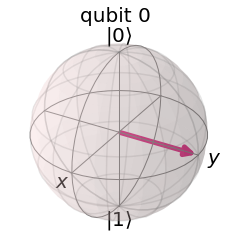

In [4]:
qc_params = qc.bind_parameters({theta: -3 * pi / 2, lam: 0, phi: pi / 2})
state = execute(qc_params,backend=vbackend).result().get_statevector()
print(state)
plot_bloch_multivector(state)

As one can see, the final state is almost the same as was provided.

## Subtask 2
The problem of this task is to optimize some function which parameters we do not know. In this case the function is $-(1/2 + 1/2 * |<\psi|\phi>| ^ 2)$. We put minus here because the swap test is "giving" 1 if the states are the same (what we want) and most optimizing algorithms work with finding minimum.

[-0.8448872 +0.31139137j  0.41215459-0.13903107j]


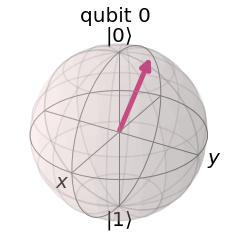

In [5]:
# create random state
tofind = random_statevector(2)
print(tofind.data)
plot_bloch_multivector(tofind)

In [6]:
theta = Parameter("theta")
lam = Parameter("lam")
phi = Parameter("phi")

var = QuantumRegister(1, "r")
qc = QuantumCircuit(var, ClassicalRegister(1, "c"))
qc.u(theta, phi, lam, 0)
qc.draw()

┌──────────────────┐
r_0: ┤ U(theta,phi,lam) ├
     └──────────────────┘
c: 1/════════════════════

In [7]:
def swap_test(tofind):
    tofind_reg = QuantumRegister(1, "q")
    res_reg = QuantumRegister(1, "res")
    qc1 = QuantumCircuit(res_reg, tofind_reg, ClassicalRegister(1, "c"))
    qc1 = qc1.combine(qc)
    qc1.initialize(tofind.data, tofind_reg)
    qc1.barrier()

    qc1.h(res_reg)
    qc1.fredkin(res_reg, var, tofind_reg)
    qc1.h(res_reg)
    qc1.measure(res_reg, 0)
    return qc1

In [8]:
swap_test(tofind).draw()

░ ┌───┐   ┌───┐┌─┐
res_0: ───────────────────────────────────────────────────░─┤ H ├─■─┤ H ├┤M├
       ┌────────────────────────────────────────────────┐ ░ └───┘ │ └───┘└╥┘
  q_0: ┤ initialize(-0.84489+0.31139j,0.41215-0.13903j) ├─░───────X───────╫─
       └──────────────┬──────────────────┬──────────────┘ ░       │       ║ 
  r_0: ───────────────┤ U(theta,phi,lam) ├────────────────░───────X───────╫─
                      └──────────────────┘                ░               ║ 
  c: 1/═══════════════════════════════════════════════════════════════════╩═
                                                                          0

The parametrized circuit is ready, let's find appropriate theta, phi and lam.

We can use gradient-free (or derivative-free) optimization algorithms. Let us use noisyopt library (https://noisyopt.readthedocs.io/en/latest/). It can work with noisy data just like the data we have here.

In [9]:
# one of the hyperparameters we can tune
# the bigger it is the smaller the error of measuring and 
SHOTS = 2048

In [10]:
def obj(x):
    theta_, phi_, lam_ = x
    qc = swap_test(tofind).bind_parameters({theta: theta_, lam: lam_, phi: phi_})
    res = execute(qc, qbackend, shots=SHOTS).result().get_counts()
    return -res['0'] / SHOTS

In [11]:
res = minimizeSPSA(obj, x0=[0, 0, 0], niter=1000, paired=False)

In [12]:
res

     fun: -0.9990234375
 message: 'terminated after reaching max number of iterations'
    nfev: 2000
     nit: 1000
 success: True
       x: array([-0.82908053,  0.0202119 , -0.13317333])

The result is not ideal since the measurements are noisy.

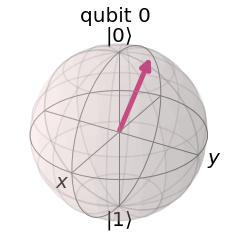

In [13]:
plot_bloch_multivector(tofind)

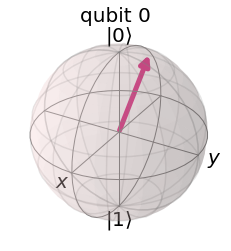

In [14]:
plot_bloch_multivector(execute(qc.bind_parameters({theta: res.x[0], phi: res.x[1], lam: res.x[2]}), vbackend).result().get_statevector())

## Subtask 3

Since the input state is a product state and each qubit is equal to |0> or |1> we can build a very simple circuit that will compare input and |0> qubits.

In [15]:
def product_state_swap_test(qubits):
    # create necessary registers
    res = QuantumRegister(len(qubits), "res")
    zero = QuantumRegister(len(qubits), "z")
    tofind = QuantumRegister(len(qubits), "find")
    
    qc = QuantumCircuit(res, tofind, zero, ClassicalRegister(len(qubits), "r"))
    
    # init input registers with unknown state
    for i, qubit in enumerate(qubits):
        state = [0, 0]
        state[qubit] = 1
        qc.initialize(state, tofind[i])
        
    qc.barrier()
    
    # make qubit by qubit swap test
    for i in range(len(qubits)):
        qc.h(res[i])
        qc.fredkin(res[i], zero[i], tofind[i])
        qc.h(res[i])
        qc.measure(res[i], i)
        
    return qc, res

In [16]:
# we are told that the state is a product state and each qubit is either |0> or |1>
tofind = [1, 0, 0, 1, 0]

In [17]:
qc = product_state_swap_test(tofind)[0]
qc.draw()

░ ┌───┐   ┌───┐                    ┌─┐            
 res_0: ────────────────────░─┤ H ├─■─┤ H ├────────────────────┤M├────────────
                            ░ ├───┤ │ └───┘┌───┐               └╥┘┌─┐         
 res_1: ────────────────────░─┤ H ├─┼───■──┤ H ├────────────────╫─┤M├─────────
                            ░ ├───┤ │   │  └───┘┌───┐           ║ └╥┘┌─┐      
 res_2: ────────────────────░─┤ H ├─┼───┼────■──┤ H ├───────────╫──╫─┤M├──────
                            ░ ├───┤ │   │    │  └───┘┌───┐      ║  ║ └╥┘┌─┐   
 res_3: ────────────────────░─┤ H ├─┼───┼────┼────■──┤ H ├──────╫──╫──╫─┤M├───
                            ░ ├───┤ │   │    │    │  └───┘┌───┐ ║  ║  ║ └╥┘┌─┐
 res_4: ────────────────────░─┤ H ├─┼───┼────┼────┼────■──┤ H ├─╫──╫──╫──╫─┤M├
        ┌─────────────────┐ ░ └───┘ │   │    │    │    │  └───┘ ║  ║  ║  ║ └╥┘
find_0: ┤ initialize(0,1) ├─░───────X───┼────┼────┼────┼────────╫──╫──╫──╫──╫─
        ├─────────────────┤ ░       │   │    │    │    │        ║  ║  ║  ║  ║ 
find_1: ┤ initialize(1,0) ├─░───────┼───X────┼────┼────┼────────╫──╫──╫──╫──╫─
        ├─────────────────┤ ░       │   │    │    │    │        ║  ║  ║  ║  ║ 
find_2: ┤ initialize(1,0) ├─░───────┼───┼────X────┼────┼────────╫──╫──╫──╫──╫─
        ├─────────────────┤ ░       │   │    │    │    │        ║  ║  ║  ║  ║ 
find_3: ┤ initialize(0,1) ├─░───────┼───┼────┼────X────┼────────╫──╫──╫──╫──╫─
        ├─────────────────┤ ░       │   │    │    │    │        ║  ║  ║  ║  ║ 
find_4: ┤ initialize(1,0) ├─░───────┼───┼────┼────┼────X────────╫──╫──╫──╫──╫─
        └─────────────────┘ ░       │   │    │    │    │        ║  ║  ║  ║  ║ 
   z_0: ────────────────────░───────X───┼────┼────┼────┼────────╫──╫──╫──╫──╫─
                            ░           │    │    │    │        ║  ║  ║  ║  ║ 
   z_1: ────────────────────░───────────X────┼────┼────┼────────╫──╫──╫──╫──╫─
                            ░                │    │    │        ║  ║  ║  ║  ║ 
   z_2: ────────────────────░────────────────X────┼────┼────────╫──╫──╫──╫──╫─
                            ░                     │    │        ║  ║  ║  ║  ║ 
   z_3: ────────────────────░─────────────────────X────┼────────╫──╫──╫──╫──╫─
                            ░                          │        ║  ║  ║  ║  ║ 
   z_4: ────────────────────░──────────────────────────X────────╫──╫──╫──╫──╫─
                            ░                                   ║  ║  ║  ║  ║ 
   r: 5/════════════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                                0  1  2  3  4

In [18]:
SHOTS = 500

In [19]:
counts = execute(qc, qbackend, shots=SHOTS).result().get_counts()

In [20]:
# count how many times 0 was measured at each res qubit

zero_counts = [0 for i in range(len(tofind))]
for key in counts.keys():
    for i, qubit in enumerate(key):
        # count only 0
        if qubit == "0":
            zero_counts[len(tofind) - i - 1] += counts[key]

In [21]:
zero_counts

[257, 500, 500, 253, 500]

In [22]:
# if count of 0s is more than 0.75 SHOTS than it is more probable that the input is 0
res = [{True: 0, False: 1}[count > SHOTS * 0.75] for count in zero_counts]
res

[1, 0, 0, 1, 0]

In [23]:
res == tofind

True

As you can see the result is the same as tofind state.